In [45]:
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import NaN
from functions_hamming import * # import functions from the .py file

from pylab import rcParams
rcParams["figure.figsize"] = 16, 4

PAYLOADSIZE = 16
PAYLOADSIZE_DEC = 12

if PAYLOADSIZE % 2 != 0:
    print("Alarm! the payload size is not even.")
NUM_16RND = (PAYLOADSIZE_DEC-2)//2 # how many 16 bits random number included in each frame
MAX_SEQ = 256 # (decimal) maximum seq number defined by the length of the seq, the length of seq is 1B

## Removing "|" after packet size

In [46]:
f = open("log_old.txt", 'r')
fn = open("log_cleaned.txt", 'w')
fn.seek(0)
lines = f.readlines()
for line in lines:
    if line[18] == '|':
        fn.write(line[0:17])
        fn.write(line[19:])
    else:
        fn.write(line)
fn.close()
f.close()

## Removing unecessary retranmissions

In [48]:
f = open("log_cleaned.txt", 'r')
fn = open("log.txt", 'w')
fn.seek(0)
lines = f.readlines()
buff_of_new_buff = []
new_buff = [str(0)] * 256
iteration_ranges = []
retransmission_interval = 5
prev_start_idx = 0
line_num = 0
start_idx = len(lines)
end_idx = len(lines) # doesnt matter what the init value is

def find_idx(num_to_check, start_looking_idx, end_looking_idx):
    for i in range(start_looking_idx, end_looking_idx):
        if getSeqNum(lines[i]) == num_to_check:
            return i

    return len(lines)

# Find where the seq num is restarting
# Bug: if the new iteration starts after the 6 elem
# but if that happens we have biger problems
while line_num < len(lines):
    # Bug: if the first 10 packages are lost, I don't care
    # Bug: if 00,01,02,03,04 seq is caused by bit error
    for num_to_check in range(retransmission_interval) or range(len(lines)):
        start_looking_idx = prev_start_idx+retransmission_interval+1+num_to_check
        idx = find_idx(num_to_check, start_looking_idx, len(lines))
        if idx < start_idx:
            start_idx = idx
            end_idx = idx
   
    # Will append even when there is nothing to append
    if start_idx == len(lines): # hasn't changed
        iteration_ranges.append([prev_start_idx, len(lines)])
        break

    # Last will be len(lines)
    iteration_ranges.append([prev_start_idx, end_idx])
    prev_start_idx = start_idx
    start_idx = len(lines) # min start_idx want init to be max
    line_num = prev_start_idx

# Generate a buffer of non duplicate packages
for r in range(len(iteration_ranges)):
    for i in range(iteration_ranges[r][1]-1, iteration_ranges[r][0]-1, -1):
        new_buff[getSeqNum(lines[i])] = lines[i]
    
    buff_of_new_buff.append(new_buff)
    new_buff = [str(0)] * 256

# Clean the buffer from initial zeros
for buff in buff_of_new_buff:
    for i in range(len(buff)-1,-1,-1):
        if buff[i] == str(0):
            del buff[i]

# Write the buffers to file
for buff in buff_of_new_buff:
    fn.writelines(buff)

fn.close()
f.close()

ValueError: invalid literal for int() with base 16: 'ke'

## Log file

**For a fair comparison between groups, must follow the output format below**
<br>$\color{red}{\text{timestamp_rx }|\text{ len [hex] } \text{ seq [hex] } \text{ payload [hex] }|\text{rssi}}$
<br>$\text{ len [hex]}$ = payload length + 1 (seq. field length [1B])
<br>$\text{ payload [hex]}$ should start with the pseudo sequence number [2B], indicates the starting byte's position in the file.
***
*Example log file output for one frame with reciever timestamp xxxx, frame length, seq number and random payload, received signal strength.*
<br>15:17:18.394 |0f 46 bd f8 f7 ea 41 ac 1b be 05 a0 7f d2 09 d4 |  -91 CRC error
<br>$\color{red}{\text{delimiter for four variables is "|" and delimiter for the payload each byte is the space " ".}}$

In [ ]:
# define the file name
filename = "log"
# import file to jupyter notebook
df = readfile("./" + filename + ".txt")
# check the imported data first 10 lines
df.head(10)

,index,time_rx,rssi,seq,payload
0,0,2023-05-19 00:00:05.085,-59,0,00 00 03 3e 17 47 e8 2e 06 d1 a5 4e 1b c9 3f e2
1,1,2023-05-19 00:00:05.151,-61,1,00 03 41 e8 1f 89 0d a8 0a ed 05 46 12 c9 ca 4a
2,2,2023-05-19 00:00:05.216,-62,2,00 05 82 b4 15 89 5d 94 05 09 03 fe 0c 09 a3 9a
3,3,2023-05-19 00:00:05.281,-65,3,00 06 c3 a2 05 09 74 86 08 e3 83 98 38 85 f8 22
4,4,2023-05-19 00:00:05.346,-65,4,00 0a 05 5a 13 86 e9 d6 09 e8 87 0e 2f c7 80 96
5,5,2023-05-19 00:00:05.736,-66,5,00 0c 44 2e 3f 05 f9 32 08 86 62 d0 39 09 bb e2
6,6,2023-05-19 00:00:05.802,-67,6,00 0f 84 12 15 86 85 7e 07 89 83 6a 01 c7 51 00
7,7,2023-05-19 00:00:05.867,-67,7,00 11 c5 7e 39 8b 53 88 0a db 63 e6 03 47 47 30
8,8,2023-05-19 00:00:05.932,-67,8,00 14 05 22 1d 87 22 ec 09 69 65 fa 27 88 b1 86
9,9,2023-05-19 00:00:05.997,-67,9,00 17 44 34 25 86 d0 82 08 3b 62 62 1b 44 42 12


In [ ]:
# delete the corrupted packets (PAYLOADSIZE + 2B pesudo sequence number)
df = df[df.payload.apply(lambda x: len(x)==((PAYLOADSIZE)*3-1))]
df.reset_index(inplace=True)

In [ ]:
# replace the resettable seq number to unresettable, for the purpose of reliability calculation
test = replace_seq(df.copy(), MAX_SEQ=256)
test.rename(columns = {'seq':'old_seq', 'new_seq':'seq'}, inplace = True)

# Time

## Definition

**Evaluation metric**
<br>*File Transmission Time: the total latency that certain amount of Data $F$ is delivered to the destination.*
<br> $File\ Delay = Rx\_timestamp[N] - Rx\_timestamp[0]$
<br> where $N$ is the last packet
***
**Interesting to look at**:
<br>*Timestamp difference*: $\Delta T[i] = Rx\_timestamp[i] - Tx\_timestamp[i]$
1. *Worst-case packet delay*: the delay of the packet that takes the longest time to traverse.
2. *Packet delay variation*: the std of the packet delay.

In [ ]:
# compute the file delay
file_delay = df.time_rx[len(df) - 1] - df.time_rx[0]
# convert the timedelta to s
file_delay_s = np.timedelta64(file_delay, "ms").astype(int) / 1000
print(f"The time it takes to transfer the file is : {file_delay}, which is {file_delay_s} seconds.")

The time it takes to transfer the file is : 0 days 00:01:08.706000, which is 68.706 seconds.


# Reliability

## Definition

**Evaluation metric**
<br>*Quality of data transfer.*
<br>*Bit Reliability*: The ratio of data bits correctly delivered to the data sink.
<br>*Bit Error Rate*: The ratio of data bits incorrectly delivered to the data sink.
$$Bit\ Reliability = 1 - BER = 1 - \frac{Number\ of\ wrong\ bit}{Total\ Number\ of\ bit\ sent}$$
***
**Interesting to look at**:
1. *Expected number of transmission*: the ratio of the number of packets correctly received by the data sink and the number of packets sent by the source.

$$ETX = \frac{Number\ of\ packet\ received}{Number\ of\ packet\ sent}$$

2. *Packet reliability*: the number of packet bit correctly delivered to next hop.

## Statistics

In [ ]:
# compute the BER for all received packets
# return the in total ber for received file, error statistics and correct file content supposed to be transmitted
ber, error, file_content = compute_ber(test, PACKET_LEN=NUM_16RND*2, MAX_SEQ=MAX_SEQ)
bit_reliability = (1-ber)*100
print(f"Bit reliability [%]: {bit_reliability}")

The total number of packets transmitted by the tag is 527.
                                               data
0        [19, 93, 31, 67, 27, 69, 37, 111, 33, 254]
10      [15, 126, 32, 107, 43, 176, 36, 75, 38, 85]
20        [26, 86, 34, 232, 20, 32, 31, 48, 37, 25]
30     [26, 20, 35, 168, 35, 140, 25, 226, 23, 194]
40        [37, 78, 31, 76, 39, 164, 49, 191, 28, 8]
...                                             ...
40910  [34, 112, 28, 234, 30, 45, 29, 210, 30, 143]
40920    [39, 234, 29, 43, 34, 80, 34, 149, 33, 85]
40930    [43, 13, 35, 206, 23, 218, 28, 96, 29, 48]
40940    [26, 88, 31, 201, 35, 146, 24, 32, 44, 40]
40950  [33, 216, 26, 183, 36, 56, 42, 234, 30, 250]

[4096 rows x 1 columns]
Error statistics dataframe is:
     seq bit_error_tmp  bit_error
0      0           [0]          0
1      1           [0]          0
2      2           [0]          0
3      3           [0]          0
4      4           [0]          0
..   ...           ...        ...
522  522           [0] 

In [ ]:
# payload example for debug purpose
# correct sequence for pesudoseq NO. '0000'
tmp = file_content.loc[int('0000', base=16), 'data']
for i in tmp:
    print("{:02x}".format(i), end=" ")

13 5d 1f 43 1b 45 25 6f 21 fe 

Text(0.5, 0, 'Seq. Number')

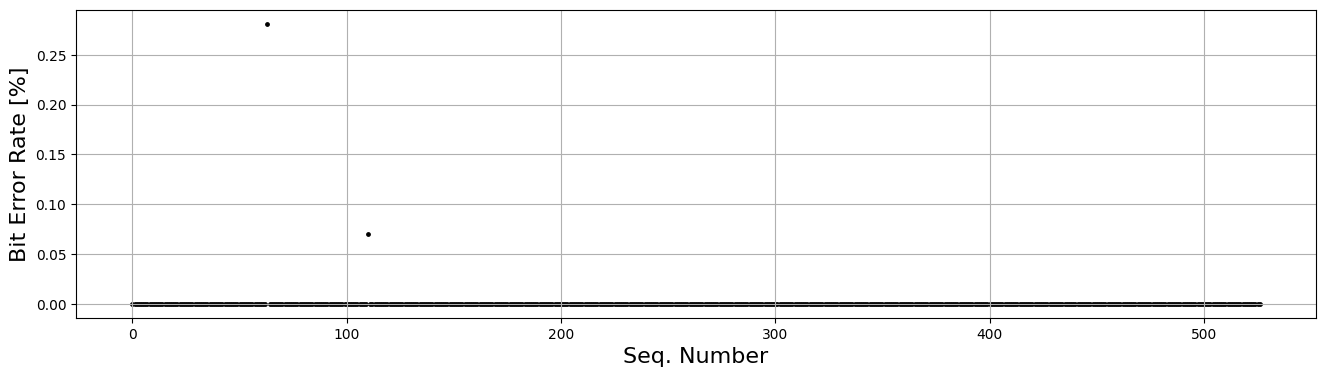

In [ ]:
# BER for each packet
plt.scatter(error.seq, error.bit_error/(PAYLOADSIZE*8), marker='o', s=6, color='black')
plt.grid()
plt.ylabel('Bit Error Rate [%]', fontsize=16)
plt.xlabel('Seq. Number', fontsize=16)

# Distance

## Definition

**The communication distance of the system.**
<br>$D_{1}$: the distance between carrier<->backscatter_tag[m]
<br>$D_{2}$: the distance between backscatter_tag<->receiver[m]
<br> Distance metric = $D_{1}^2D_{2}^2$
<br>

In [ ]:
# record the distance
dis_carrier_tag = 0.15
dis_tag_rx = 0.04

dis_metric = dis_carrier_tag**2*dis_tag_rx**2
print(f"Distance metric is: {dis_metric}")

Distance metric is: 3.6e-05


# Radarplot

**Please pay attention to the unit**
<br> <font color='red'>Time</font>: use second as unit
<br> <font color='red'>Reliability</font>: use the percent as unit
<br> <font color='red'>Distance</font>: use meter as unit
<br>**Metics = [Time(s), Reliability(%), Distance(m)]**
<br> <font color='red'>Always keep the reference in your plot.</font>
<br> Tips: for ploting, time metric uses $\frac{1}{Time}*1000$ as the time metric, the higher the value the better the system performance

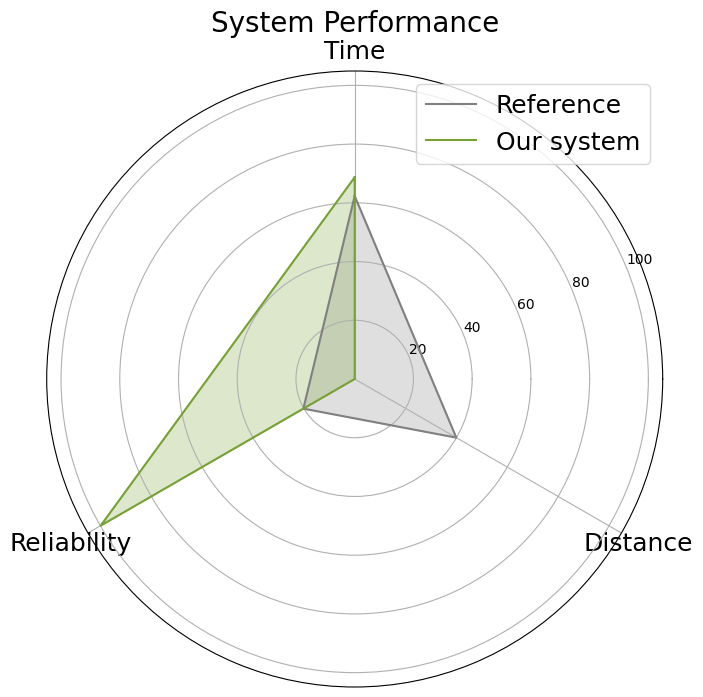

In [ ]:
metrics = [file_delay_s, bit_reliability, dis_metric]
radar_plot(metrics)